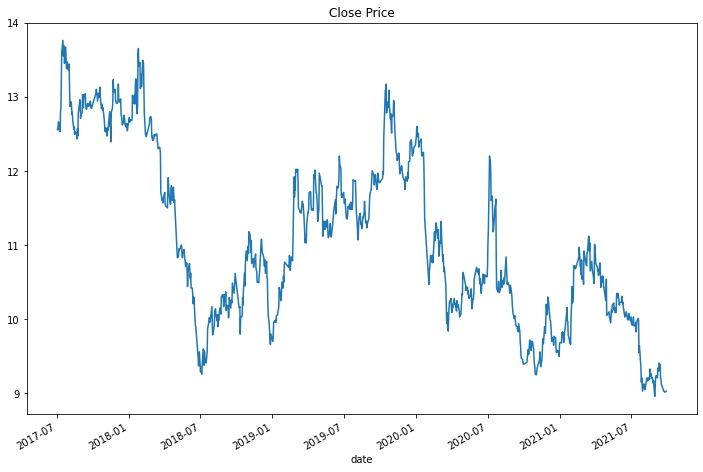

In [1]:
import pandas as pd
import numpy as np
import datetime

from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import numpy as np
import datetime

from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

if __name__ == '__main__':
    stock_df = pd.read_csv('D600000.csv')
    # 格式化时间
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    stock_df.set_index('date', inplace=True)
    # 提取 close
    stock_df = stock_df['close']
    plt.figure(figsize=(12,8))
    stock_df.plot()
    plt.title('Close Price')

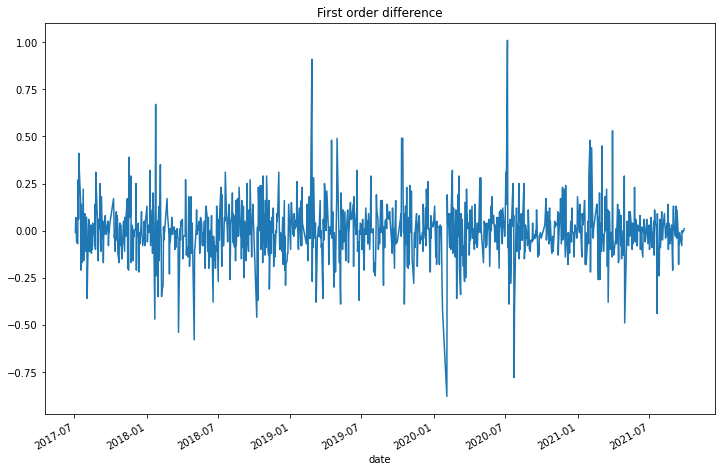

In [2]:
    stock_diff = stock_df - stock_df.shift(1)
    stock_diff.dropna(inplace=True)
    plt.figure(figsize=(12,8))
    stock_diff.plot()
    plt.title('First order difference')
    plt.show()

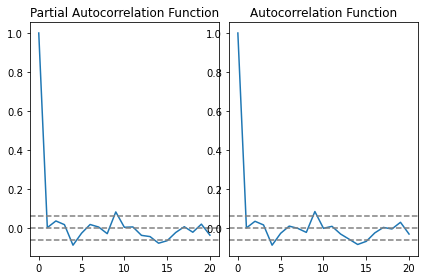

In [3]:
    lag_pacf = pacf(stock_diff, nlags=20)
    lag_acf = acf(stock_diff, nlags=20)

    # Plot PACF:
    plt.subplot(121)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

    # Plot ACF:
    plt.subplot(122)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')

    plt.show()

In [4]:
    stock_df = stock_df.dropna()
    model = ARIMA(stock_df, order=(2, 1, 2))
    result = model.fit()
    print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1034
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 517.599
Method:                       css-mle   S.D. of innovations              0.147
Date:                Mon, 04 Oct 2021   AIC                          -1023.197
Time:                        19:48:52   BIC                           -993.550
Sample:                             1   HQIC                         -1011.947
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0034      0.005     -0.736      0.462      -0.013       0.006
ar.L1.D.close    -0.2375      0.095     -2.490      0.013      -0.424      -0.051
ar.L2.D.close    -0.8211      0.087     

之后20天预测
2021-09-28    9.023964
2021-09-29    9.006940
2021-09-30    9.008906
2021-10-01    9.015384
2021-10-04    9.005197
2021-10-05    8.995264
2021-10-06    8.998954
2021-10-07    8.999200
2021-10-08    8.989078
2021-10-11    8.984247
2021-10-12    8.986672
2021-10-13    8.983029
2021-10-14    8.974869
2021-10-15    8.972765
2021-10-18    8.972931
Freq: B, dtype: float64


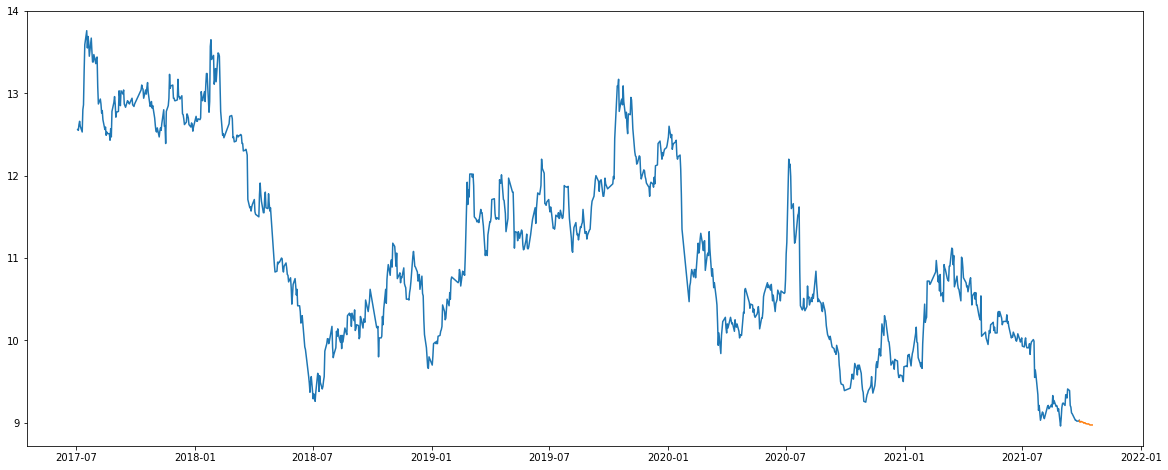

In [5]:
    print('之后20天预测')
    pred = result.forecast(15)
    pred = pd.Series(pred[0], index=pd.period_range('20210928', '20211017', freq='B'))
    print(pred)
    plt.figure(figsize=(20, 8))
    plt.plot(stock_df)
    plt.plot(pred)
    plt.show()

In [6]:
    ts = result.predict()
    df_fill = stock_df[ts.index]
    print('RMSE:{}'.format(np.sqrt(sum((ts - df_fill) ** 2) / ts.size)))

RMSE:11.123258973161803


In [7]:
    # 残差校验
    '''
    主要针对残差进行正态性检验和自相关性检验。
    残差满足正态性，主要是为了残差集中于某一个数值，如果该值与0很接近，则它实际服从均值为0的正态分布，即它是一个白噪声。
    白噪声是指功率谱密度在整个频域内均匀分布的噪声。白噪声或白杂讯，是一种功率频谱密度为常数的随机信号或随机过程。换句话说，此信号在各个频段上的功率是一样的，由于白光是由各种频率（颜色）的单色光混合而成，因而此信号的这种具有平坦功率谱的性质被称作是“白色的”，此信号也因此被称作白噪声。
    残差满足非自相关性，主要是为了在残差中不再包括AR或者MA过程产生的序列。

    为什么残差要是白噪声？
    得到白噪声序列，就说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的，
    残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。如果残差不是白噪声，就说明残差中还有有用的信息，需要修改模型或者进一步提取。

    '''
    resid = result.resid  # 赋值
    # Durbin-Watson）检验
    '''
    当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验
    '''
    print(sm.stats.durbin_watson(result.resid.values))
    # 白噪声检验
    '''
    时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，
    其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，
    拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，
    如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。
    '''
    r, q, p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
    data = np.c_[range(1, 41), r[1:], q, p]
    table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
    print(table.set_index('lag'))



1.9632479100254996
            AC          Q  Prob(>Q)
lag                                
1.0   0.018375   0.350125  0.554042
2.0  -0.009911   0.452084  0.797685
3.0   0.012842   0.623421  0.891050
4.0  -0.045147   2.743252  0.601668
5.0  -0.032704   3.856658  0.570233
6.0  -0.019933   4.270686  0.640097
7.0   0.012566   4.435377  0.728484
8.0   0.003233   4.446290  0.814782
9.0   0.065970   8.994613  0.437772
10.0 -0.012728   9.164097  0.516604
11.0  0.025466   9.843198  0.544544
12.0 -0.020373  10.278257  0.591564
13.0 -0.069427  15.335448  0.286882
14.0 -0.084914  22.907908  0.061785
15.0 -0.053664  25.935268  0.038709
16.0 -0.022833  26.483858  0.047589
17.0 -0.004358  26.503862  0.065757
18.0 -0.000767  26.504483  0.088770
19.0  0.034722  27.776856  0.087818
20.0 -0.029994  28.727288  0.093270
21.0  0.028609  29.592802  0.100481
22.0 -0.005104  29.620380  0.127987
23.0 -0.040027  31.317994  0.115179
24.0  0.011779  31.465144  0.140819
25.0  0.036194  32.855946  0.134709
26.0 -0.0